https://machinelearningmastery.com/a-gentle-introduction-to-graph-neural-networks-in-python/

In [1]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

In [2]:
# Define graph dataset
edge_index = torch.tensor([
    [0, 1, 0, 2, 0, 4, 2, 4],
    [1, 0, 2, 0, 4, 0, 4, 2],
], dtype=torch.long)

In [3]:
# Define data features
node_features = torch.tensor([
    [25, 1],  # Person 0 (25 years old, likes sports)
    [30, 0],  # Person 1 (30 years old, does not like sports)
    [22, 1],  # Person 2 (22 years old, likes sports)
    [35, 0],  # Person 3 (35 years old, does not like sports)
    [27, 1],  # Person 4 (27 years old, likes sports)
], dtype=torch.float)

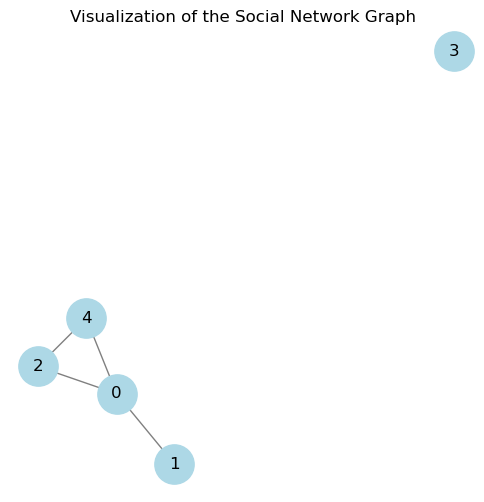

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert the edge_index tensor to a list of edge tuples
edge_list = edge_index.t().tolist()

# Create a NetworkX graph from the edge list
G = nx.Graph()
G.add_edges_from(edge_list)

# Optionally, include nodes that might be isolated (e.g., person 3)
G.add_nodes_from(range(node_features.size(0)))

# Generate a layout for the nodes
pos = nx.spring_layout(G, seed=42)  # fixed seed for reproducibility

# Draw the graph with labels
plt.figure(figsize=(6, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Visualization of the Social Network Graph")
plt.axis('off')
plt.show()

# Modelo

In [5]:
# Define dataset labels
num_friends = torch.tensor([3, 1, 2, 0, 3])
labels = (num_friends >= 2).long()

In [6]:
# Mask for separating training and testing data
train_mask = torch.tensor([1, 1, 1, 0, 0], dtype=torch.bool)
data = Data(x=node_features, edge_index=edge_index, y=labels, train_mask=train_mask)

In [7]:
# Define model
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim) 
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)  # Activation function
        x = self.conv2(x, edge_index)
        return x

# Instantiate model
model = GNN(input_dim=2, hidden_dim=4, output_dim=2)

In [8]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train model
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 7.9340
Epoch 10, Loss: 4.0511
Epoch 20, Loss: 1.4821
Epoch 30, Loss: 0.7289
Epoch 40, Loss: 0.6683
Epoch 50, Loss: 0.6486
Epoch 60, Loss: 0.6078
Epoch 70, Loss: 0.6103
Epoch 80, Loss: 0.6016
Epoch 90, Loss: 0.5996


In [9]:
# Test model
model.eval()
with torch.no_grad():
    predictions = model(data).argmax(dim=1)

print("\nFinal Predictions (1=Popular, 0=Not Popular):", predictions.tolist())


Final Predictions (1=Popular, 0=Not Popular): [1, 1, 1, 1, 1]
